In [1]:
using Pandas
using DataFrames
using PyCall
using PyPlot
using CSV
using LsqFit
using Printf

pickle = pyimport("pickle")
numpy = pyimport("numpy")
scipy_integrate = pyimport("scipy.integrate")

┌ Info: Precompiling Pandas [eadc2687-ae89-51f9-a5d9-86b5a6373a9c]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


PyObject <module 'scipy.integrate' from '/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/scipy/integrate/__init__.py'>

In [2]:
function load_pickle(filename)
    @pywith pybuiltin("open")(filename,"rb") as f begin
       data = nothing
       data = pickle.load(f)
       return data
    end
end

load_pickle (generic function with 1 method)

In [ ]:
data = load_pickle("data.pkl")

In [ ]:
fig, ax = subplots(1,2, figsize=(12,5))
data["freq"].hist(ax=ax[1], bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

f = data["freq"].sort_values(ascending=false)
ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

In [ ]:
tissue = "Bone-Marrow_c-kit"

data = Dict()
data["data"]=load_pickle("mca/data_$(tissue)_data.pkl")
data["mazzolini"]=load_pickle("mca/data_$(tissue)_mazzolini.pkl")
#data["null_1"]=load_pickle("data_$(tissue)_null_1.pkl")

In [ ]:
fig, ax = subplots(2,2, figsize=(12,10))
f = data["data"]["means_nonzero"].sort_values(ascending=false)

ax[1].hist(f/f.sum(),  bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-6,1e-1)
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)


f = data["data"]["means"].sort_values(ascending=false)

ax[3].hist(f/f.sum(), bins=10)
ax[3].set_yscale("log")
ax[3].set_xlabel("Frequency", fontsize=24)
ax[3].set_ylabel("pdf", fontsize=24)

ax[4].plot(f/f.sum())
ax[4].set_xscale("log")
ax[4].set_yscale("log")
ax[4].set_ylim(1e-6,1e-1)
ax[4].set_xlabel("Rank, i", fontsize=24)
ax[4].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

In [ ]:
bins=10
rang = (0-0.5/bins, 1+0.5/bins)
fig, ax = subplots(1,2, figsize=(10,5))

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls="--", label="mazzolini")
data["null_1"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls=":", label="null")

ax[1].legend(fontsize=20)
ax[1].set_xlabel("O_i")

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls="--", label="mazzolini")
data["null_1"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls=":", label="null")

ax[2].set_yscale("log")
ax[2].legend(fontsize=20)
ax[2].set_xlabel("O_i")

fig.savefig("null_1_U.pdf")

In [ ]:
fig, ax = PyPlot.subplots()

function fx(X)
    ret = Vector{Float64}()
    for x in X.values
        append!(ret, exp(-x))
    end
   return ret
end

ax.scatter(data["data"]["means"], 1-data["data"]["O"], alpha=0.3, label="data")
ax.plot(data["data"]["means"].sort_values(), fx(data["data"]["means"].sort_values()), c="yellow", ls="--", alpha=0.5, label="1-exp(-x)")
ax.scatter(data["mazzolini"]["means"], 1-data["mazzolini"]["O"], c="orange", alpha=0.2, label="mazzolini")
ax.scatter(data["null_1"]["means"], 1-data["null_1"]["O"], marker="x", s=10, c="green", alpha=0.8, label="null_1")


ax.legend()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(1e-4,30)
ax.set_ylim(-0.1,1.1)

ax.set_xlabel("mean", fontsize=24)
ax.set_ylabel("P(0)", fontsize=24)

fig.savefig("null_1_P_mean.pdf")
show()

In [ ]:
data["data"]["means"].sort_values()

In [ ]:
fig, ax = PyPlot.subplots()
ax.plot(data["data"]["freq"].sort_values(ascending=false).values, label="data")
ax.plot(data["mazzolini"]["freq"].sort_values(ascending=false).values, label="mazzolini")
ax.plot(data["null_1"]["freq"].sort_values(ascending=false).values, label="null")

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Rank, i", fontsize=24)
ax.set_ylabel("f_i", fontsize=24)
show()

fig.savefig("null_1_zipf.pdf")

In [ ]:
fig, ax = PyPlot.subplots(figsize=(10,5))
ax.scatter(data["data"]["M"].values, data["data"]["diffWords"].values, label="data")
ax.scatter(data["mazzolini"]["M"].values, data["mazzolini"]["diffWords"].values, label="mazzolini")
ax.scatter(data["null_1"]["M"].values, data["null_1"]["diffWords"].values, label="null")


ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(500,data["data"]["M"].max()+1e4)
ax.set_ylim(10,data["mazzolini"]["diffWords"].max()+5e3)

ax.set_xlabel("Size", fontsize=24)

ax.set_ylabel("# genes expressed", fontsize=24)
show()

fig.savefig("null_1_heaps.pdf")

In [ ]:
for g in data["data"]["freq"].sort_values(ascending=false).index
    println(g)
end

In [ ]:
keys(load_pickle("data_$(tissue)_data.pkl"))

In [13]:
tissues

Base.Generator{Base.Iterators.Filter{var"#56#58",Array{String,1}},var"#55#57"}(var"#55#57"(), Base.Iterators.Filter{var"#56#58",Array{String,1}}(var"#56#58"(), ["100_most_expressed_in_10_tissues.txt", "100_most_expressed_in_65_tissues.txt", "100_most_expressed_in_68_tissues.txt", "10_most_expressed_in_65_tissues.txt", "10_most_expressed_in_68_tissues.txt", "GSE108097-GPL17021_series_matrix.txt", "all_hist.pdf", "cv2_mean_dense_mca.pdf", "cv2_var_mca.pdf", "cvmean_loglog.pdf"  …  "mean_occ.pdf", "p0m_allgenes.pdf", "p0m_fbrelationship.pdf", "rank_plot_counts_gtex.pdf", "var_mean_dense_mca.pdf", "zipf_GTEx.pdf", "zipf_alldatasets.pdf", "zipf_alldatasets_fit.pdf", "zipf_alltissues.pdf", "zipf_alltissues_noLactation_mca.pdf"]))

In [78]:
integrals = []
used_tissues = []
tissues = (split(split(f,"data_")[2],"_data")[1] for f in readdir("mca") if occursin(".pkl",f) && !occursin("mazzolini",f) && !occursin("data_all.pkl",f))

function fit_func(x,a,b)
    return a*x^b
end

for tissue in tissues
    println(tissue)
    integral=load_pickle("mca/data_$(tissue)_data.pkl")["heaps_integral"][1]
    params = load_pickle("mca/data_$(tissue)_data.pkl")["heaps_fit"]
    integral=scipy_integrate.quad(fit_func, 500, 1000, args=(params[1], params[2]))[1]
    append!(integrals, integral::Float64)
end
integrals = DataFrames.DataFrame(data=integrals, index = collect(tissues))
sort!(integrals, rev=true)

Bladder
Bone-Marrow_c-kit
Bone-Marrow
Bone_Marrow_Mesenchyme
Brain
Embryonic-Mesenchyme
Embryonic-Stem-Cell
Fetal-Liver
Fetal_Brain
Fetal_Intestine
Fetal_Lung
Fetal_Stomache
Kidney
Liver
Lung
Male_Fetal_Gonad
MammaryGland.Involution
MammaryGland.Lactation
MammaryGland.Pregnancy
MammaryGland.Virgin
Mesenchymal-Stem-Cell-Cultured
Muscle
Neonatal-Calvaria
Neonatal-Heart
Neonatal-Muscle
Neonatal-Rib
Neonatal-Skin
Ovary
Pancreas
Peripheral_Blood
Placenta
Prostate
Small-Intestine
Spleen
Stomach
Testis
Thymus
Trophoblast-Stem-Cell
Uterus


,data,index
,Any,SubStrin…
1,3.12677e5,Testis
2,2.98625e5,Thymus
3,291510.0,Ovary
4,2.80862e5,Male_Fetal_Gonad
5,2.77514e5,Bladder
6,273619.0,Mesenchymal-Stem-Cell-Cultured
7,2.72447e5,Uterus
8,2.70601e5,Fetal_Brain
9,2.67507e5,Brain


In [87]:
CSV.write("integral_heaps.csv", integrals)

"integral_heaps.csv"

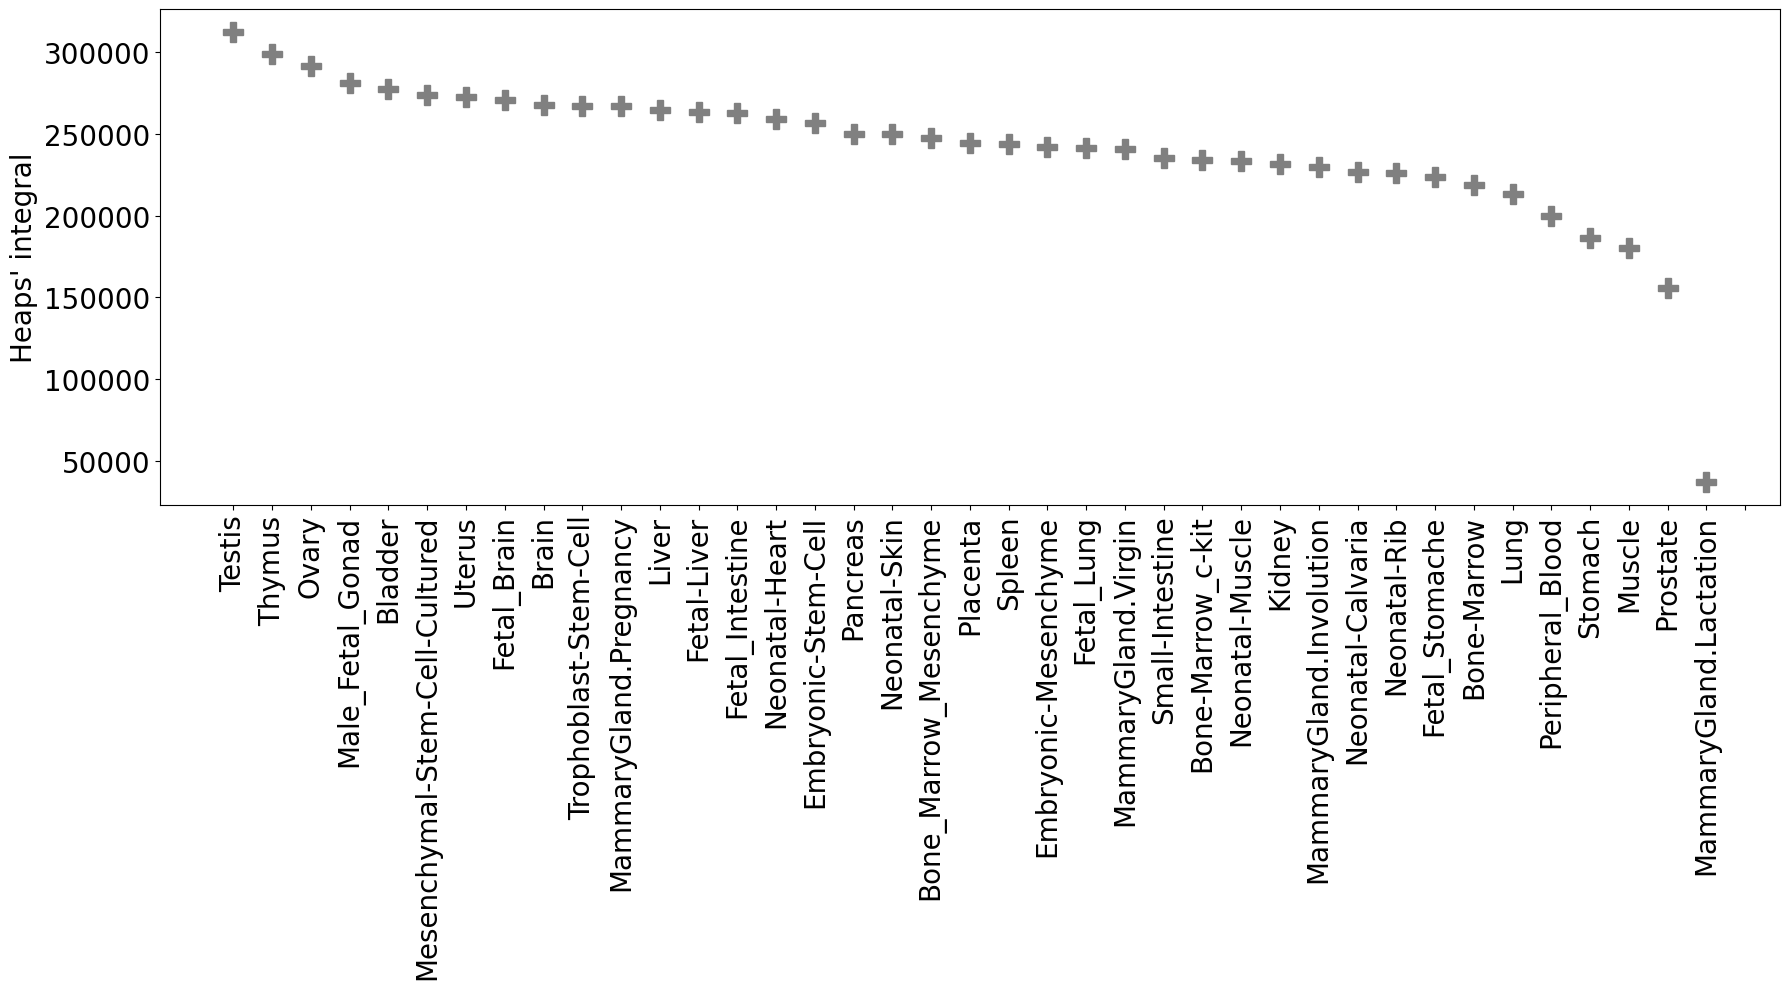

In [88]:
fig = PyPlot.figure(figsize=(18,10))
PyPlot.plot(integrals.data, marker="P", c="gray", lw=0, ms=15)
locs, labels = xticks()
PyPlot.xticks(0:length(integrals.index), labels = integrals.index, rotation=90)
PyPlot.ylabel("Heaps' integral", fontsize=20)
fig.savefig("itegral_heapfs_scatter_plot_mca.pdf")
fig.savefig("itegral_heapfs_scatter_plot_mca.png")

In [74]:
CSV.write("integral.csv", integrals)

"integral.csv"

In [ ]:
integrals.rank=1:length(integrals.index)

In [ ]:
mca_tm = CSV.read("integral.csv")
select!(mca_tm,Not(:GTex))
mca_tm = DataFrames.dropmissing(mca_tm)
sort!(mca_tm,:TM)
mca_tm.TM = 1:9
sort!(mca_tm,:MCA)
mca_tm.MCA = 1:9
sort!(mca_tm, :MCA)

In [ ]:
fig = PyPlot.figure(figsize=(7,7))
PyPlot.scatter(mca_tm.MCA, mca_tm.TM, c="gray")
PyPlot.xlabel("MCA integral's rank", fontsize=22)
PyPlot.ylabel("TM integral's rank", fontsize=22)
fig.savefig("heaps_rank_both.pdf")

In [ ]:
data["data"]=load_pickle("mca/data_Bone-Marrow_c-kit_data.pkl")
data["mazzolini"]=load_pickle("mca/data_Bone-Marrow_c-kit_mazzolini.pkl")


fig, ax = PyPlot.subplots(figsize=(18,10))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3)

ax.set_xlabel("Reads per cell", fontsize=22)
ax.set_ylabel("Number of expressed genes", fontsize=22)


PyPlot.show()
fig.savefig("heaps_boneMarrow_MCA.pdf")

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,10))

ax.scatter(data["data"]["M"], data["data"]["diffWords"], c="gray", alpha=0.3, label="data")
ax.scatter(data["mazzolini"]["M"], data["mazzolini"]["diffWords"], c="red", alpha=0.3, label="Sampling model")

ax.set_xlabel("Reads per cell", fontsize=22)
ax.set_ylabel("Number of expressed genes", fontsize=22)

ax.legend(fontsize=22)

PyPlot.show()
fig.savefig("heaps_boneMarrow_sampling_MCA.pdf")

In [ ]:
f_gtex = CSV.read("A_gtex.dat", header=true).abundance
f_gtex = sort(f_gtex./sum(f_gtex), rev=true);

In [ ]:
f_mca = load_pickle("mca/data_all.pkl")["freq"]
f_mca = sort(f_mca./sum(f_mca), rev=true);

In [ ]:
f_tm = load_pickle("tm/data_all.pkl")["freq"]
f_tm = sort(f_tm./sum(f_tm), rev=true);

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,10))

X = collect(1:1e5)

ax.plot(X,[1e-1*x^-0.8 for x in X], ls="--", color="gray")

ax.plot(f_gtex, label="GTEx", lw=5, color="gray")
ax.plot(f_mca, label="Mouse Cell Atlas", lw=5, color="blue")
ax.plot(f_tm, label="Tabula Muris", lw=5, color="red")


ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=22)


ax.legend(fontsize=22)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=22)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=22)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets.pdf")

In [ ]:
fit_func = function(X, p)
    return p[1]*[x^(-p[2]) for x in X]
end

In [ ]:
optimize_fit = function(f)
    maxmimum_r2 = -Inf
    optimal_fit = nothing
    optimal_limits = nothing
    for left_side::Int32=range(2,30,step=2), right_side::Int32=range(2e3,2e4,step=20)
        #println(left_side," ", right_side)
        x_data = left_side:right_side
        y_data = f[left_side:right_side]
        fit = curve_fit(fit_func, x_data, y_data, [1e-1, 0.8])
        popt, pcov = (coef(fit), estimate_covar(fit))
        residuals = [y - fit_func(x, popt)[1] for (x, y) in zip(x_data,y_data)]
        ss_res = sum([r^2 for r in residuals])
        ss_tot = sum([y^2 for y in [y1 - mean(y_data) for y1 in y_data]])
        r_squared = 1 - (ss_res / ss_tot)
        if r_squared > maxmimum_r2
            maxmimum_r2 = r_squared
            optimal_fit = fit
            optimal_limits = (left_side, right_side)
        end
    end
    return maxmimum_r2, optimal_fit, optimal_limits
end

In [ ]:
r2, fit, limits = optimize_fit(f_tm)

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,10))

X = collect(1:1e5)

popt = coef(fit)

ax.plot(f_gtex.Column1, label="GTEx", lw=5, color="gray", alpha=0.8)
ax.plot(f_mca, label="Mouse Cell Atlas", lw=5, color="blue", alpha=0.8)
ax.plot(f_tm, label="Tabula Muris", lw=5, color="red", alpha=0.8)

#ax.plot(X,[1e-1*x^-0.8 for x in X], ls="--", color="gray")
ax.plot(X,[popt[1]*x^-popt[2] for x in X], ls=":", lw=5, color="green", label="$(@sprintf("%.2f", popt[1]))*x^-$(@sprintf("%.2f", popt[2]))")

#ax.annotate(L"$k*i^{-0.8}$", (1e2,1e-2), fontsize=22)
ax.annotate("R^2=$(@sprintf("%.4f", r2))", (1e2,1e-2), fontsize=22)

ax.vlines([limits[1] limits[2]], 1e-9, 1e-1, colors="gray", ls="-.", alpha =.5)
ax.annotate("$(limits[1])", (limits[1],2e-9), fontsize=22, alpha=0.8)
ax.annotate("$(limits[2])", (limits[2],2e-9), fontsize=22, alpha=0.8)


ax.legend(fontsize=22)
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(L"Rank, $i$", fontsize=22)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=22)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
show()

fig.savefig("zipf_alldatasets_fit_tm.pdf")

In [ ]:
df = CSV.read("mainTable_Stomach.csv");
df_values = convert(Array, select!(df,Not(1)));
df_values = reshape(df_values,1,size(df_values)[1]*size(df_values)[2])

In [ ]:
fig, ax = PyPlot.subplots(figsize=(18,10))

ax.hist(df_values[df_values .> 0], lw=4, histtype="step")

ax.set_xlabel(L"Rank, $i$", fontsize=22)
ax.set_ylabel(L"Frequency, $f_i$", fontsize=22)

ax.set_yscale("log")
show()

fig.savefig("all_hist.pdf")

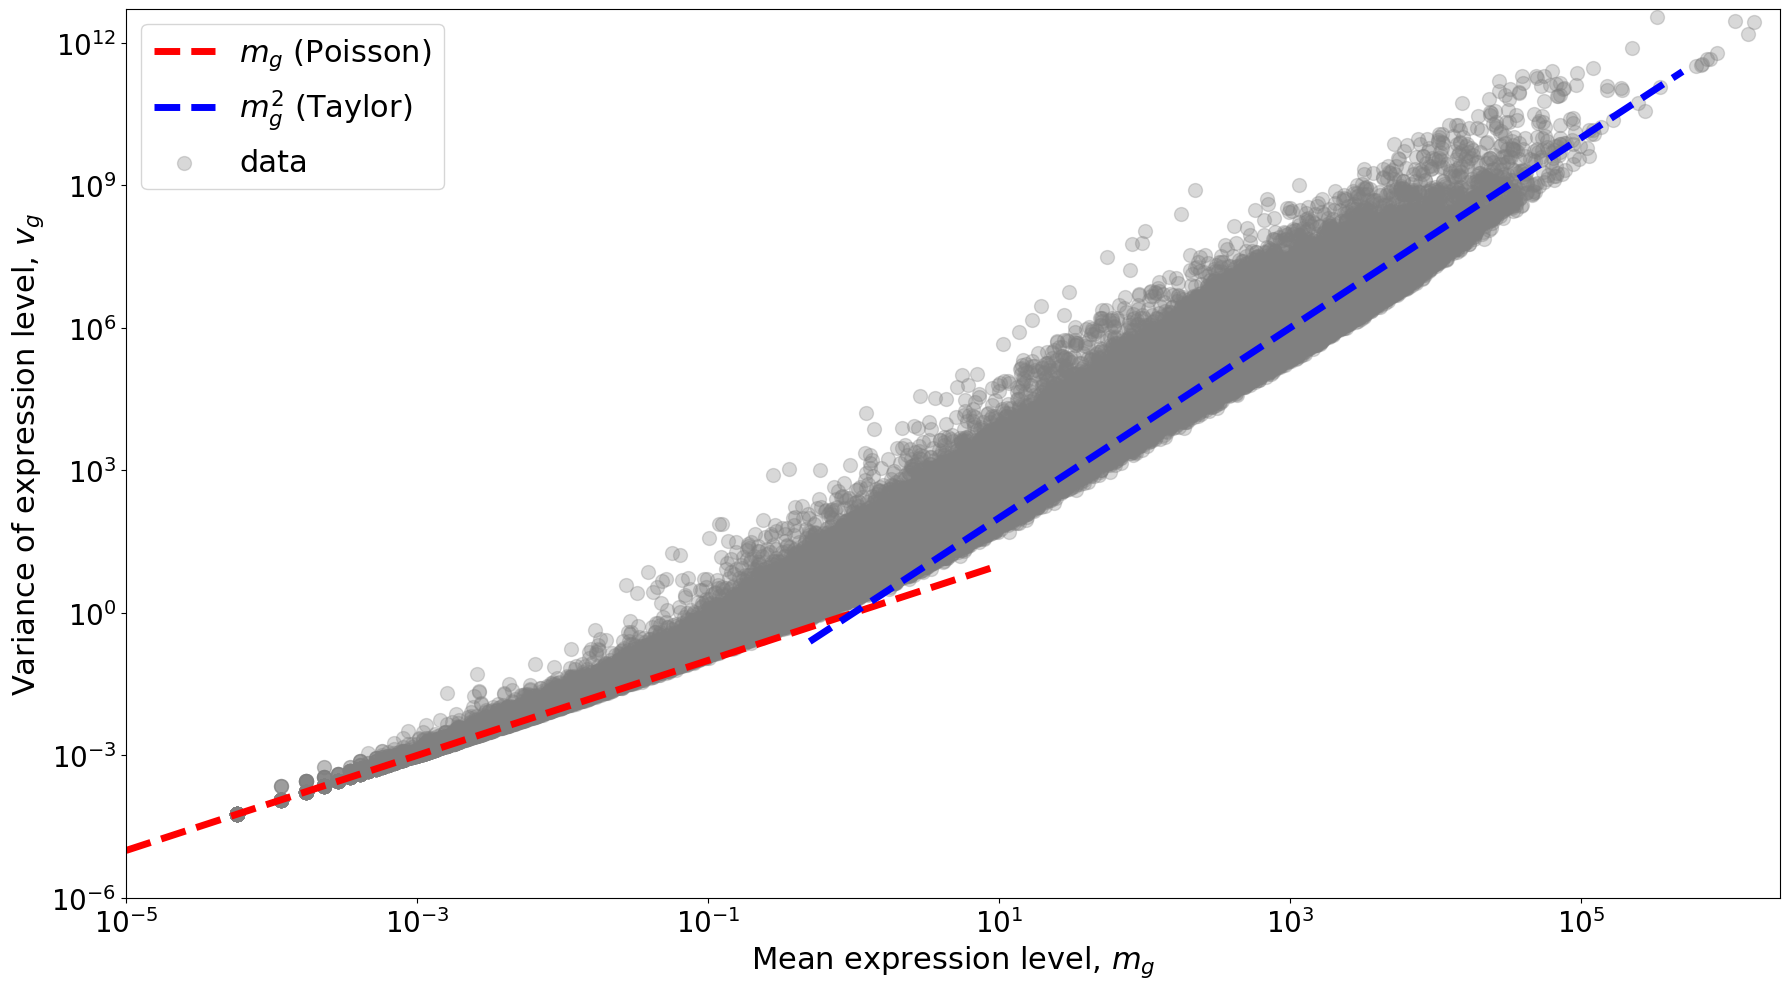

In [4]:
data = load_pickle("data_gtex.pkl")

fig, ax = PyPlot.subplots(figsize=(18,10))

ax.scatter(data["means"], data["var"], c="gray", alpha=0.3, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,x, lw=5, color="red", ls="--", label=L"$m_g$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[x_i^2 for x_i in x], lw=5, color="blue", ls="--", label=L"$m_g^2$ (Taylor)")


ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=22)
ax.set_ylabel(L"Variance of expression level, $v_g$", fontsize=22)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e-5, data["means"].max()*1.5)
ax.set_ylim(1e-6, data["var"].max()*1.5)

ax.legend(fontsize=22)

PyPlot.show()
fig.savefig("sigma2_var_gtex.pdf")

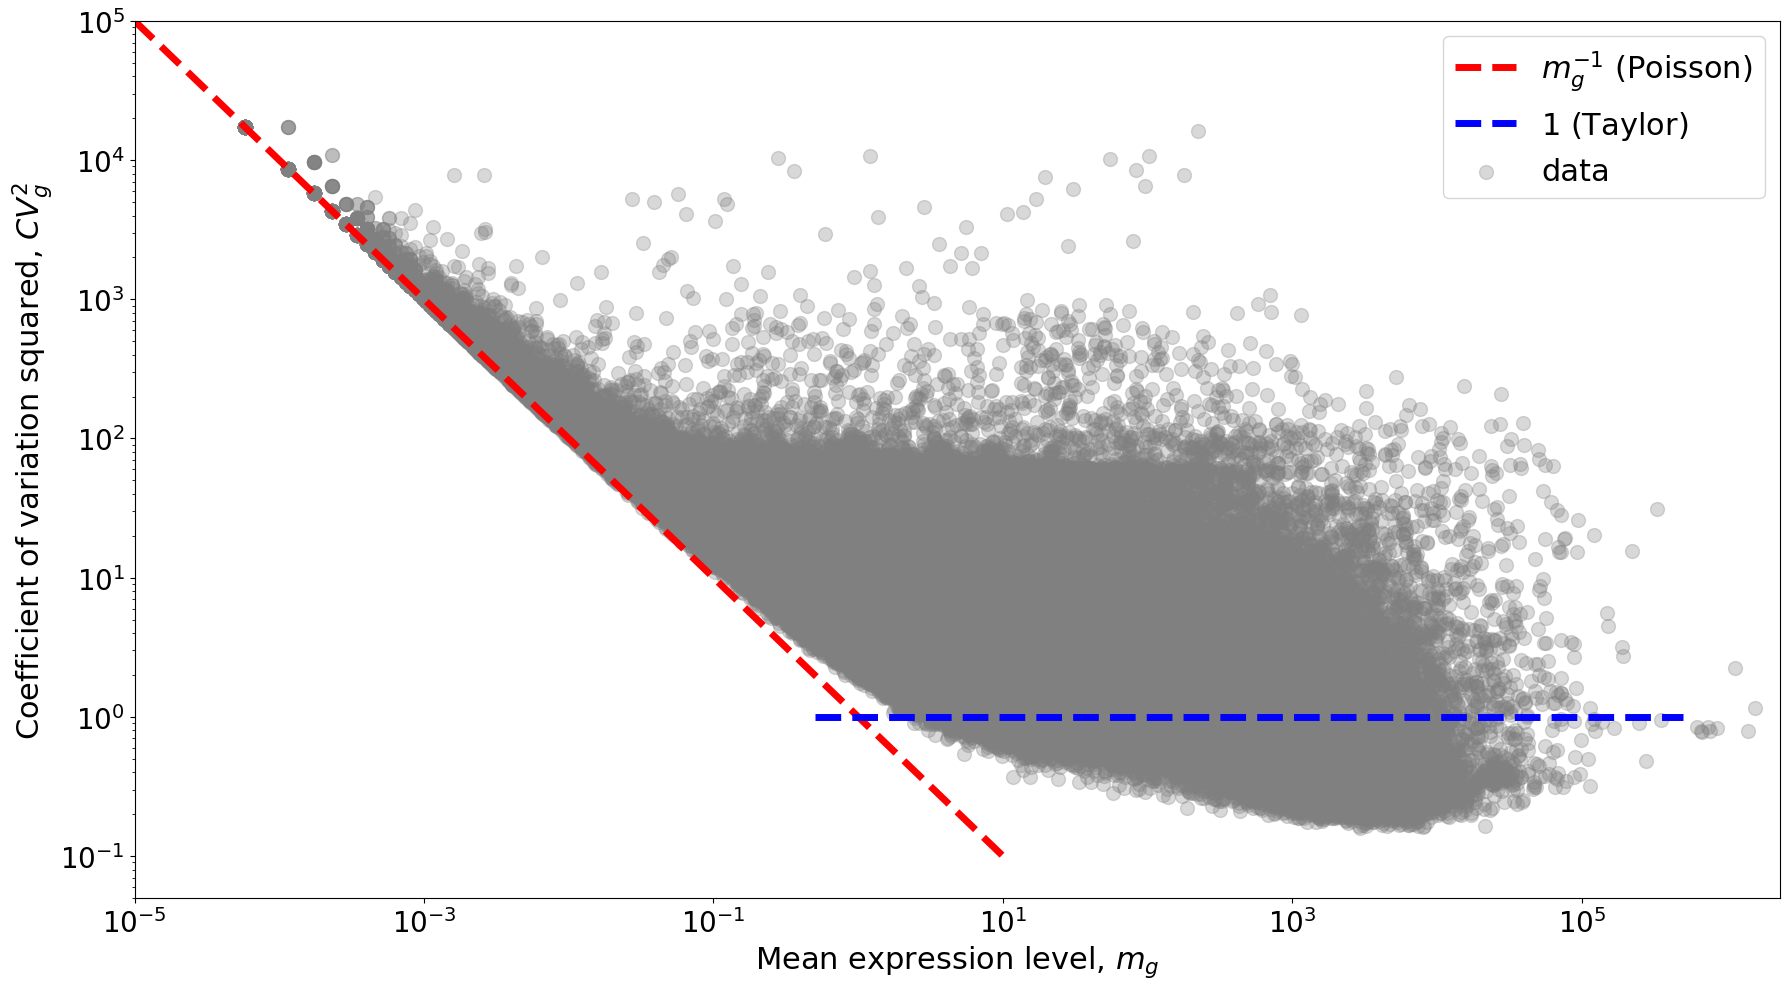

In [7]:
fig, ax = PyPlot.subplots(figsize=(18,10))

means = [m for (m,v) in zip(data["means"], data["var"]) if v>1e-6]
vars = [v for v in data["var"] if v>1e-6]

ax.scatter(means, [v/m/m for (m,v) in zip(means, vars)], c="gray", alpha=0.3, label="data")

x = range(1e-5,10, length=10)
ax.plot(x,[1/x_i for x_i in x], lw=5, color="red", ls="--", label=L"$m_g^{-1}$ (Poisson)")

x = range(0.5,5e5, length=10)
ax.plot(x,[1 for _ in x], lw=5, color="blue", ls="--", label=L"$1$ (Taylor)")


ax.set_ylabel(L"Coefficient of variation squared, $CV^2_g$", fontsize=22)
ax.set_xlabel(L"Mean expression level, $m_g$", fontsize=22)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e-5, maximum(means)*1.5)
ax.set_ylim(5e-2, 1e5)

ax.legend(fontsize=22)

PyPlot.show()
fig.savefig("cv2_var_gtex.pdf")